In [1]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#### Conversion factors

In [2]:
Ry = 13.605693122990 # eV
Bohr = 0.529177210544 # Angstrom

#### Problem 1 (10 pts): convergence of total (absolute) energies w.r.t cutoff energies
- 8 Atoms per unit cell 
- Threshold at $5$ meV/atom
- Energy per atom = total energy / 8
- Cutoff energies are [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 1000] Ry

In [3]:
filepath = "Problem1/bulk_energy_vs_kinetic_energy_cutoff.dat"
df = pd.read_csv(filepath, header=None, names=["E [Ry]"]) / 8
df["E_cutoff [Ry]"] = (df.index + 1) * 10
df.loc[df.index[-1], "E_cutoff [Ry]"] = 1000

df["E [eV]"] = df["E [Ry]"] * Ry 
df["E_cutoff [eV]"] = df["E_cutoff [Ry]"] * Ry

last_Ry = df["E [Ry]"].iloc[-1]
last_eV = df["E [eV]"].iloc[-1]

# Check for convergence
energy_threshold = 5e-3  # meV/atom
df["Convergence [Ry]"] = np.abs(df["E [Ry]"] - last_Ry)
df["Convergence [eV]"] = np.abs(df["E [eV]"] - last_eV)
df["Converged"] = df["Convergence [eV]"] < energy_threshold
df.head(10)

,E [Ry],E_cutoff [Ry],E [eV],E_cutoff [eV],Convergence [Ry],Convergence [eV],Converged
0,-13.059457,10,-177.682959,136.056931,0.787185,10.710193,False
1,-13.616509,20,-185.262042,272.113862,0.230132,3.131110,False
2,-13.769740,30,-187.346851,408.170794,0.076902,1.046301,False
3,-13.822856,40,-188.069540,544.227725,0.023785,0.323612,False
4,-13.840685,50,-188.312113,680.284656,0.005956,0.081039,False
5,-13.845503,60,-188.377659,816.341587,0.001139,0.015493,False
6,-13.846501,70,-188.391237,952.398519,0.000141,0.001915,True
7,-13.846627,80,-188.392957,1088.455450,0.000014,0.000195,True
8,-13.846636,90,-188.393074,1224.512381,0.000006,0.000078,True
9,-13.846636,100,-188.393084,1360.569312,0.000005,0.000069,True


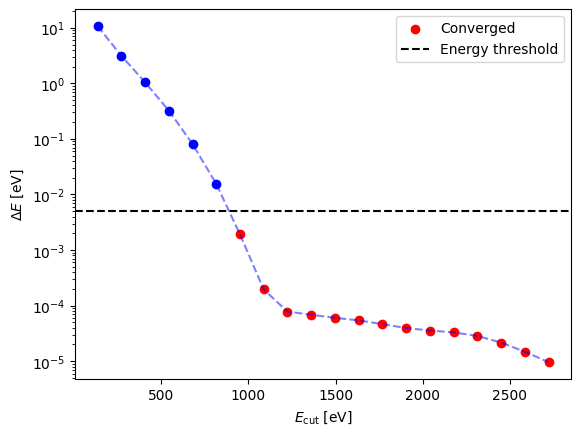

In [4]:
plt.plot(df["E_cutoff [eV]"][:-1], df["Convergence [eV]"][:-1], color="blue", linestyle="--", alpha=0.5)

# Scatter non converged points
plt.scatter(df[~df["Converged"]]["E_cutoff [eV]"], df[~df["Converged"]]["Convergence [eV]"], marker="o", color="blue")

# Scatter converged points
plt.scatter(df[df["Converged"]]["E_cutoff [eV]"][:-1], df[df["Converged"]]["Convergence [eV]"][:-1], marker="o", color="red", label="Converged")

plt.axhline(energy_threshold, color='black', linestyle='--', label="Energy threshold")
plt.xlabel(r"$E_{\rm cut}$ [eV]")
plt.ylabel(r"$\Delta E$ [eV]")
plt.yscale("log")
plt.legend()
plt.show()

#### Problem 2 (10 pts): convergence of forces w.r.t cutoff energies

- **Ca** atom moved by +0.05 in the $z$ direction
- Force convergence threshold of 10 meV/$\text{\AA}$ 
- Cutoff energies are [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 1000] Ry

In [5]:
filename = "Problem2/simulations/forces.dat"
data = []

def extract_forces(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    e_cut = None
    atom_data = []
    
    for line in lines:
        if "ecut=" in line:
            match_ecut = re.search(r"ecut=([\d\.]+)", line)
            if match_ecut:
                e_cut = float(match_ecut.group(1))

        if "atom" in line and "force" in line:
            match = re.search(r"atom\s+(\d+)\s+type\s+(\d+)\s+force\s+=\s+([-\d\.]+)\s+([-\d\.]+)\s+([-\d\.]+)", line)
            if match:
                atom = int(match.group(1))
                atom_type = int(match.group(2))
                force1 = float(match.group(3))
                force2 = float(match.group(4))
                force3 = float(match.group(5))
                atom_data.append([e_cut, atom, atom_type, force1, force2, force3])
    
    return atom_data

data.extend(extract_forces(filename))
columns = ['E_cut [Ry]', 'Atom', 'Type', 'f_x', 'f_y', 'f_z [Ry/Bohr]']
df = pd.DataFrame(data, columns=columns).sort_values(by=['E_cut [Ry]', 'Atom']).drop(columns=['f_x', 'f_y']).reset_index()  # drop f_x, f_y since they are always zero
df['f_z [eV/Ang]'] = df['f_z [Ry/Bohr]'] * Ry / Bohr
df["E_cut [eV]"] = df["E_cut [Ry]"] * Ry

df_atom_1 = df[df["Atom"] == 1].copy()
df_atom_2 = df[df["Atom"] == 2].copy()

In [6]:
force_threshold = 10e-3 # eV/Angstrom

last_f_atom_1 = df_atom_1["f_z [eV/Ang]"].iloc[-1]
last_f_atom_2 = df_atom_2["f_z [eV/Ang]"].iloc[-1]

In [7]:
df_atom_1["Convergence"] = np.abs(df_atom_1["f_z [eV/Ang]"] - last_f_atom_1)
df_atom_2["Convergence"] = np.abs(df_atom_2["f_z [eV/Ang]"] - last_f_atom_2)
df_atom_1["Converged"] = df_atom_1["Convergence"] < force_threshold
df_atom_2["Converged"] = df_atom_2["Convergence"] < force_threshold

df_atom_1.head(10)

,index,E_cut [Ry],Atom,Type,f_z [Ry/Bohr],f_z [eV/Ang],E_cut [eV],Convergence,Converged
0,0,10.0,1,1,-0.150135,-3.860138,136.056931,2.751733,False
2,24,20.0,1,1,-0.093613,-2.406879,272.113862,1.298474,False
4,28,30.0,1,1,-0.035322,-0.908156,408.170794,0.200248,False
6,30,40.0,1,1,-0.045319,-1.165196,544.227725,0.056792,False
8,32,50.0,1,1,-0.042895,-1.102862,680.284656,0.005542,True
10,34,60.0,1,1,-0.043204,-1.110816,816.341587,0.002412,True
12,36,70.0,1,1,-0.043128,-1.108855,952.398519,0.000450,True
14,38,80.0,1,1,-0.043135,-1.109053,1088.455450,0.000648,True
16,40,90.0,1,1,-0.043148,-1.109376,1224.512381,0.000972,True
18,2,100.0,1,1,-0.043149,-1.109410,1360.569312,0.001006,True


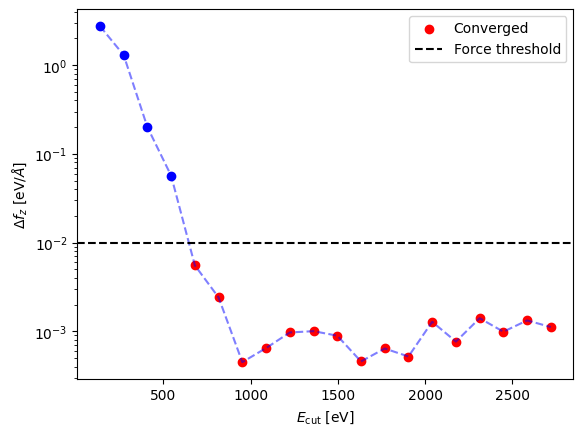

In [8]:
plt.plot(df_atom_1["E_cut [eV]"][:-1], df_atom_1["Convergence"][:-1], linestyle="--", color="blue", alpha=0.5)
plt.scatter(df_atom_1[~df_atom_1["Converged"]]["E_cut [eV]"], df_atom_1[~df_atom_1["Converged"]]["Convergence"], marker="o", color="blue")
plt.scatter(df_atom_1[df_atom_1["Converged"]]["E_cut [eV]"][:-1], df_atom_1[df_atom_1["Converged"]]["Convergence"][:-1], marker="o", color="red", label="Converged")
plt.axhline(force_threshold, color='black', linestyle='--', label="Force threshold")
plt.xlabel(r"$E_{\rm cut}$ [eV]")
plt.ylabel(r"$\Delta f_z$ [eV/$\AA$]")
plt.yscale("log")
plt.legend()    
plt.show()

#### Problem 3 (10 pts): Convergence of the total (absolute) energies w.r.t $\vec k$ points mesh

- $\vec k$ mesh with [2, 4, 6, 8, 10, 12, 14, 16]
- chosen value of $E_{\rm cut}=80$ Ry (converged value for both forces and total energy in problems 1 and 2)
- Same energy threshold for convergence as in Problem 1 (5 meV/atom)

In [9]:
energies_filepath = "Problem3/simulations/energies_vs_k.dat"

with open(energies_filepath, 'r') as file:
    data = file.read()

pattern = r"k=(\d+)\.out:!.*total energy\s+=\s+(-?\d+\.\d+) Ry"
matches = re.findall(pattern, data)

df = pd.DataFrame(matches, columns=["k", "E [Ry]"]).astype({"k": int, "E [Ry]": float})
df["E [Ry]"] = df["E [Ry]"] / 8  # Energy per atom
df["E [eV]"] = df["E [Ry]"] * Ry
df = df.sort_values(by="k")

In [10]:
number_k_points_filepath = "Problem3/simulations/number_k_points.dat"

with open(number_k_points_filepath, 'r') as file:
    data = file.read()

pattern_k_points =  r"k=(\d+)\.out:.*number of k points\s*=\s*(\d+)"
matches = re.findall(pattern_k_points, data)

df_k_points = pd.DataFrame(matches, columns=["k", "n_k irreducible"]).astype({"k": int, "n_k irreducible": int})
df_k_points = df_k_points.sort_values(by="k")
df = pd.merge(df, df_k_points, on="k")
df["n_k"] = df["k"] ** 3

In [11]:
energy_threshold = 5e-3 # eV/atom
last_energy = df["E [eV]"].iloc[-1]
df["Convergence"] = np.abs(df["E [eV]"] - last_energy)
df["Converged"] = df["Convergence"] < energy_threshold
df

,k,E [Ry],E [eV],n_k irreducible,n_k,Convergence,Converged
0,2,-13.843726,-188.353490,3,8,4.000098e-02,False
1,4,-13.846627,-188.392957,8,64,5.346017e-04,True
2,6,-13.846665,-188.393475,16,216,1.578260e-05,True
3,8,-13.846666,-188.393492,29,512,5.782420e-07,True
4,10,-13.846666,-188.393491,47,1000,5.102135e-08,True
5,12,-13.846666,-188.393492,72,1728,5.612348e-07,True
6,14,-13.846666,-188.393492,104,2744,6.632775e-07,True
7,16,-13.846666,-188.393491,145,4096,0.000000e+00,True


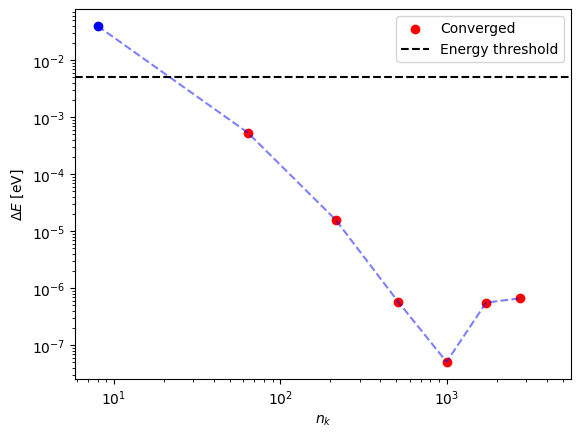

In [12]:
plt.plot(df["n_k"][:-1], df["Convergence"][:-1], linestyle="--", color="blue", alpha=0.5)
plt.scatter(df[~df["Converged"]]["n_k"], df[~df["Converged"]]["Convergence"], marker="o", color="blue")
plt.scatter(df[df["Converged"]]["n_k"], df[df["Converged"]]["Convergence"], marker="o", color="red", label="Converged")
plt.axhline(energy_threshold, color='black', linestyle='--', label="Energy threshold")
plt.xlabel(r"$n_k$")
plt.ylabel(r"$\Delta E$ [eV]")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

#### Problem 4 (10 pts): Convergence of forces w.r.t the size of the $\vec k$ points mesh
- **Ca** atom displaced by +0.05 $\text{\AA}$ in the $z$ direction 
- $\vec k$ mesh with [2, 4, 6, 8, 10, 12, 14, 16]
- chosen value of $E_{\rm cut}=80$ Ry (converged value for both forces and total energy in problems 1 and 2)
- same force threshold as in Problem 2 (10 meV/$\text{\AA}$ )

In [13]:
force_filepath = "Problem4/simulations/forces.dat"
data = []

def extract_forces_k(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        
    k = None
    atom_data = []
    for line in lines:
        if "k=" in line:
            match_k = re.search(r"k=([\d\.]+)", line)
            if match_k:
                k = float(match_k.group(1))
        if "atom" in line and "force" in line:
            match = re.search(r"atom\s+(\d+)\s+type\s+(\d+)\s+force\s+=\s+([-\d\.]+)\s+([-\d\.]+)\s+([-\d\.]+)", line)
            if match:
                atom = int(match.group(1))
                atom_type = int(match.group(2))
                force1 = float(match.group(3))
                force2 = float(match.group(4))
                force3 = float(match.group(5))
                atom_data.append([k, atom, atom_type, force1, force2, force3])
    return atom_data

data.extend(extract_forces_k(force_filepath))
df = pd.DataFrame(data, columns=['k', 'Atom', 'Type', 'f_x', 'f_y', 'f_z [Ry/Bohr]'])\
        .sort_values(by=['k', 'Atom']).reset_index().drop(columns=['f_x', 'f_y', 'index']).astype({'k': int}) # drop f_x, f_y since they are always zero


In [14]:
df['f_z [eV/Ang]'] = df['f_z [Ry/Bohr]'] * Ry / Bohr
df_atom_1 = df[df["Atom"] == 1].copy()
df_atom_2 = df[df["Atom"] == 2].copy()

force_threshold = 10e-3 # eV/Angstrom
last_f_atom_1 = df_atom_1["f_z [eV/Ang]"].iloc[-1]
last_f_atom_2 = df_atom_2["f_z [eV/Ang]"].iloc[-1]
df_atom_1["Convergence"] = np.abs(df_atom_1["f_z [eV/Ang]"] - last_f_atom_1)
df_atom_2["Convergence"] = np.abs(df_atom_2["f_z [eV/Ang]"] - last_f_atom_2)
df_atom_1["Converged"] = df_atom_1["Convergence"] < force_threshold
df_atom_2["Converged"] = df_atom_2["Convergence"] < force_threshold

df_atom_1

,k,Atom,Type,f_z [Ry/Bohr],f_z [eV/Ang],Convergence,Converged
0,2,1,1,-0.016847,-0.433161,0.685076,False
2,4,1,1,-0.043135,-1.109053,0.009184,True
4,6,1,1,-0.043527,-1.119122,0.000884,True
6,8,1,1,-0.043533,-1.119272,0.001035,True
8,10,1,1,-0.043489,-1.118138,0.000099,True
10,12,1,1,-0.043497,-1.118362,0.000125,True
12,14,1,1,-0.043491,-1.118200,0.000038,True
14,16,1,1,-0.043493,-1.118237,0.000000,True


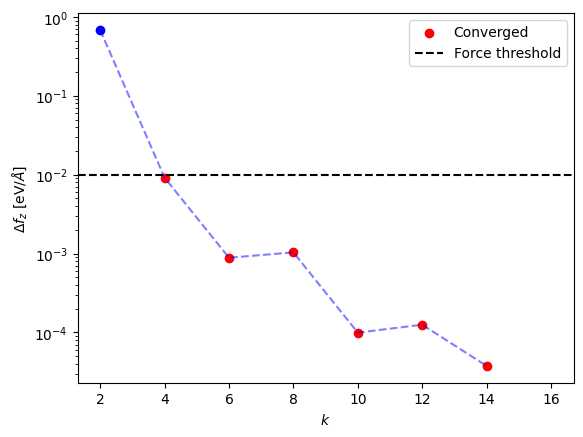

In [15]:
plt.plot(df_atom_1["k"][:-1], df_atom_1["Convergence"][:-1], linestyle="--", color="blue", alpha=0.5)
plt.scatter(df_atom_1[~df_atom_1["Converged"]]["k"], df_atom_1[~df_atom_1["Converged"]]["Convergence"], marker="o", color="blue")
plt.scatter(df_atom_1[df_atom_1["Converged"]]["k"], df_atom_1[df_atom_1["Converged"]]["Convergence"], marker="o", color="red", label="Converged")
plt.axhline(force_threshold, color='black', linestyle='--', label="Force threshold")
plt.xlabel(r"$k$")
plt.ylabel(r"$\Delta f_z$ [eV/$\AA$]")
plt.legend()
plt.yscale('log')
plt.show()

#### Problem 5 (5 pts): Convergence of total energy differences w.r.t energy cutoff
- Chosen $\vec k$ mesh: 6x6x6 (convergence of both forces and energies in Problem 3 and 4)
- Energy cutoffs: $[20, 30, 40, 50, 60, 70, 80, 90, 100, 1000]$ Ry, 1000 Ry being the reference for convergence.
- Threshold for energy difference: $5$ meV/atom

Energy computed for each cutoff with first $a=9a_0$ and then $a =9.05 a_0$ with $a_0$ the Bohr radius

In [16]:
print(f"Original lattice constant : {9*Bohr:.3f} Angstrom")
print(f"Second lattice constant : {9.05*Bohr:.3f} Angstrom")

Original lattice constant : 4.763 Angstrom
Second lattice constant : 4.789 Angstrom


In [17]:
filepath_1 = "Problem5/simulations/energies_a=9.00.dat"
filepath_2 = "Problem5/simulations_2/energies_a=9.05.dat"

def extract_energies(filepath):
    with open(filepath, "r") as f:
        data = f.read()
    pattern = r"ecut=(\d+)\.k=\d+.*?=\s*(-?\d+\.\d+)"
    matches = re.findall(pattern, data)

    df = pd.DataFrame(matches, columns=["E_cut [Ry]", "E [Ry]"])
    df = df.astype({"E_cut [Ry]": int, "E [Ry]": float})
    df_sorted = df.sort_values(by="E_cut [Ry]").reset_index(drop=True)
    df_sorted["E [Ry]"] = df_sorted["E [Ry]"] / 8  # Energy per atom
    return df_sorted


def merge_data(df_1, df_2): 
    df = pd.merge(df_1, df_2, on="E_cut [Ry]", suffixes=("_a9.00", "_a9.05"))

    # Compute energy difference
    df["Delta E [Ry]"] = np.abs(df["E [Ry]_a9.05"] - df["E [Ry]_a9.00"])

    # Conversion to eV
    df["E_cut [eV]"] = df["E_cut [Ry]"] * Ry
    df["Delta E [eV]"] = df["Delta E [Ry]"] * Ry

    # Convergence check
    energy_threshold = 5e-3  # meV/atom
    df["Convergence"] = df["Delta E [eV]"] < energy_threshold

    return df

df_1 = extract_energies(filepath_1)
df_2 = extract_energies(filepath_2)
df = merge_data(df_1, df_2)
display(df)

,E_cut [Ry],E [Ry]_a9.00,E [Ry]_a9.05,Delta E [Ry],E_cut [eV],Delta E [eV],Convergence
0,20,-13.617706,-13.618429,0.000723,272.113862,0.009839,False
1,30,-13.768892,-13.769171,0.000280,408.170794,0.003807,True
2,40,-13.823007,-13.823233,0.000226,544.227725,0.003075,True
3,50,-13.840700,-13.840842,0.000143,680.284656,0.001945,True
4,60,-13.845558,-13.845646,0.000088,816.341587,0.001193,True
5,70,-13.846536,-13.846633,0.000097,952.398519,0.001314,True
6,80,-13.846665,-13.846758,0.000093,1088.455450,0.001270,True
7,90,-13.846673,-13.846767,0.000093,1224.512381,0.001271,True
8,100,-13.846674,-13.846768,0.000093,1360.569312,0.001271,True
9,1000,-13.846679,-13.846773,0.000093,13605.693123,0.001270,True


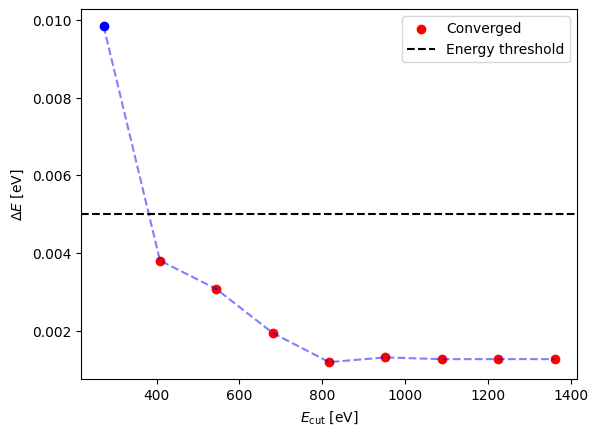

In [18]:
# Plotting the results
plt.plot(df["E_cut [eV]"][:-1], df["Delta E [eV]"][:-1], linestyle="--", color="blue", alpha=0.5)
plt.scatter(df[~df["Convergence"]]["E_cut [eV]"], df[~df["Convergence"]]["Delta E [eV]"], marker="o", color="blue")
plt.scatter(df[df["Convergence"]]["E_cut [eV]"][:-1], df[df["Convergence"]]["Delta E [eV]"][:-1], marker="o", color="red", label="Converged")
plt.axhline(energy_threshold, color='black', linestyle='--', label="Energy threshold")
plt.xlabel(r"$E_{\rm cut}$ [eV]")
plt.ylabel(r"$\Delta E$ [eV]")
plt.legend()
plt.show()

In [19]:
# Second attempt with k=4
filepath_1 = "Problem5/simulations_k=4_a=9.00/energies.dat"
filepath_2 = "Problem5/simulations_k=4_a=9.05/energies.dat" 

df_1 = extract_energies(filepath_1)
df_2 = extract_energies(filepath_2)
df = merge_data(df_1, df_2)
display(df)

,E_cut [Ry],E [Ry]_a9.00,E [Ry]_a9.05,Delta E [Ry],E_cut [eV],Delta E [eV],Convergence
0,20,-13.616509,-13.618941,0.002432,272.113862,0.033088,False
1,30,-13.769740,-13.769392,0.000348,408.170794,0.004734,True
2,40,-13.822856,-13.823004,0.000148,544.227725,0.002014,True
3,50,-13.840685,-13.840829,0.000144,680.284656,0.001957,True
4,60,-13.845503,-13.845631,0.000128,816.341587,0.001747,True
5,70,-13.846501,-13.846591,0.000091,952.398519,0.001235,True
6,80,-13.846627,-13.846722,0.000095,1088.455450,0.001288,True
7,90,-13.846636,-13.846730,0.000094,1224.512381,0.001285,True
8,100,-13.846636,-13.846731,0.000094,1360.569312,0.001284,True
9,1000,-13.846641,-13.846736,0.000094,13605.693123,0.001284,True


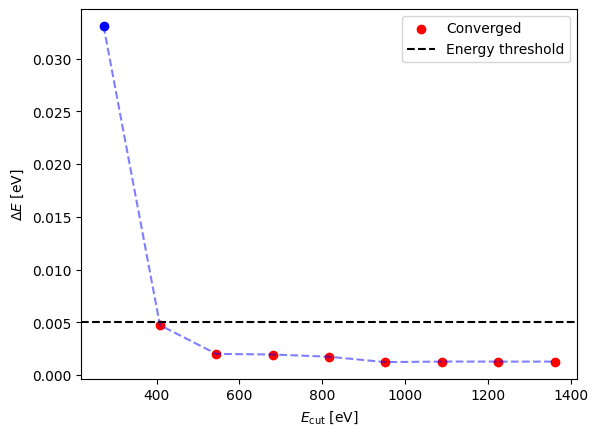

In [22]:
# Plotting the results
plt.plot(df["E_cut [eV]"][:-1], df["Delta E [eV]"][:-1], linestyle="--", color="blue", alpha=0.5)
plt.scatter(df[~df["Convergence"]]["E_cut [eV]"], df[~df["Convergence"]]["Delta E [eV]"], marker="o", color="blue")
plt.scatter(df[df["Convergence"]]["E_cut [eV]"][:-1], df[df["Convergence"]]["Delta E [eV]"][:-1], marker="o", color="red", label="Converged")
plt.axhline(energy_threshold, color='black', linestyle='--', label="Energy threshold")
plt.xlabel(r"$E_{\rm cut}$ [eV]")
plt.ylabel(r"$\Delta E$ [eV]")
plt.legend()
plt.show()

#### Problem 6 (10 pts): Discussion on problems 1 to 5

#### Problem 7 (5 pts): Determination of the equilibrium lattice parameter

#### Problem 8 (20 pts): Determination of the bulk modulus

#### Problem 9 (20 pts): $C_{11}$, $C_{12}$ and $C_{44}$ elastic constants of **CaO**